In [1]:
!pip install tensorflow
!pip install keras

In [6]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import csv
import pandas as pd
import csv

# Load data, handling potential quoting issues and skipping bad lines
df = pd.read_csv('IMDB_Dataset.csv', on_bad_lines='skip', quoting=csv.QUOTE_MINIMAL, engine='python')

# Inspect the first few rows
df.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


<ipython-input-7-d6bca4256806>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='viridis')


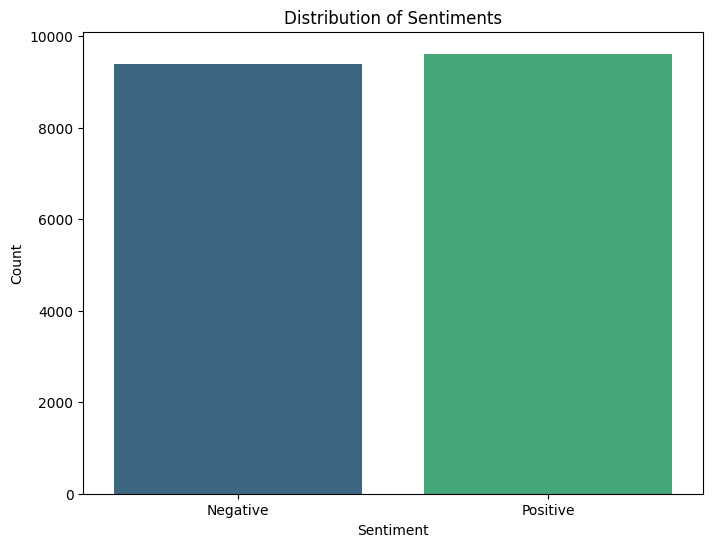

In [7]:
# Distribution of Sentiments
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df, palette='viridis')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
plt.show()


In [8]:
# Preprocess text
def preprocess_text_basic(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

df['cleaned_review'] = df['review'].apply(preprocess_text_basic)

# Convert sentiment to binary
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)


In [9]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_review'], df['sentiment'], test_size=0.2, random_state=42)

# Tokenization and Padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding sequences
max_length = 200
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')


In [10]:
# Build RNN model with adjustments
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_length),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(128),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

from tensorflow.keras.optimizers import Adam

# Compile model with adjusted learning rate
model.compile(optimizer=Adam(learning_rate=0.00005), loss='binary_crossentropy', metrics=['accuracy'])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [11]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
# Train model with more epochs if needed
history = model.fit(X_train_pad, y_train, epochs=15, batch_size=64, validation_data=(X_test_pad, y_test),
                    callbacks=[early_stopping, model_checkpoint])



Epoch 1/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.4968 - loss: 0.6933 - val_accuracy: 0.5084 - val_loss: 0.6927
Epoch 2/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.5214 - loss: 0.6924 - val_accuracy: 0.5510 - val_loss: 0.6901
Epoch 3/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6503 - loss: 0.6112 - val_accuracy: 0.8480 - val_loss: 0.3615
Epoch 4/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.8553 - loss: 0.3471 - val_accuracy: 0.8598 - val_loss: 0.3248
Epoch 5/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.8971 - loss: 0.2647 - val_accuracy: 0.8645 - val_loss: 0.3167
Epoch 6/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.9111 - loss: 0.2352 - val_accuracy: 0.8648 - val_loss: 0.3244
Epoch 7/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.9213 - loss: 0.2223 - val_accuracy: 0.8519 - val_loss: 0.3778
Epoch 8/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9287 - loss: 0.1974 - val_

119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1920
           1       0.88      0.84      0.86      1882

    accuracy                           0.86      3802
   macro avg       0.87      0.86      0.86      3802
weighted avg       0.87      0.86      0.86      3802



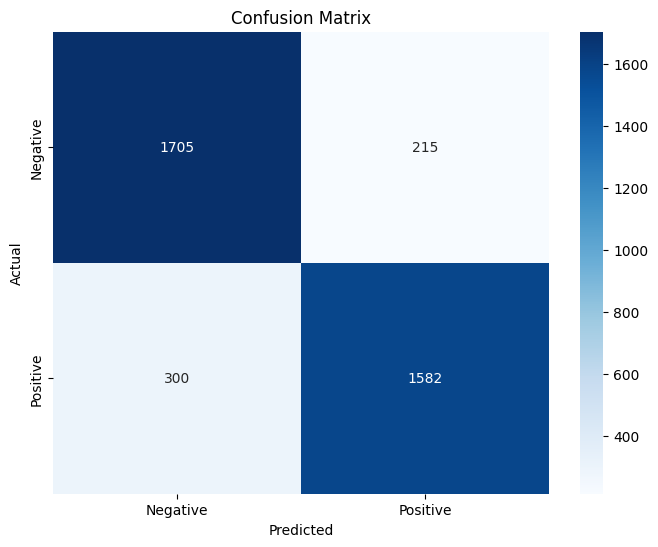

In [12]:
# Load best model
model.load_weights('best_model.keras')

# Evaluate model
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


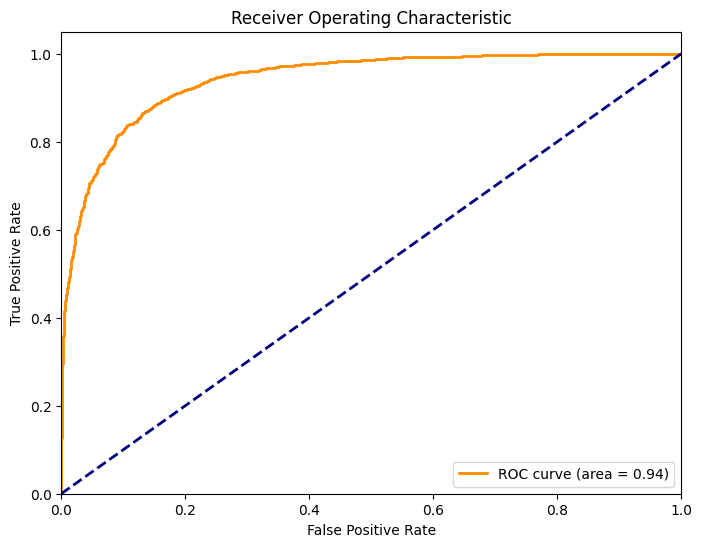

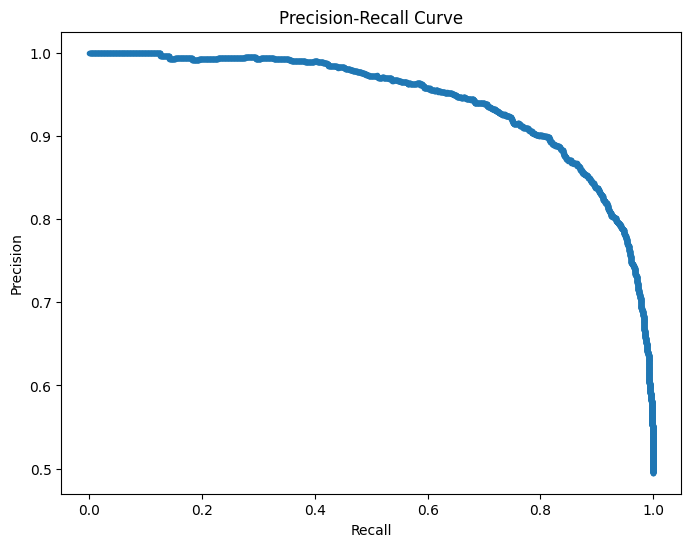

In [13]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


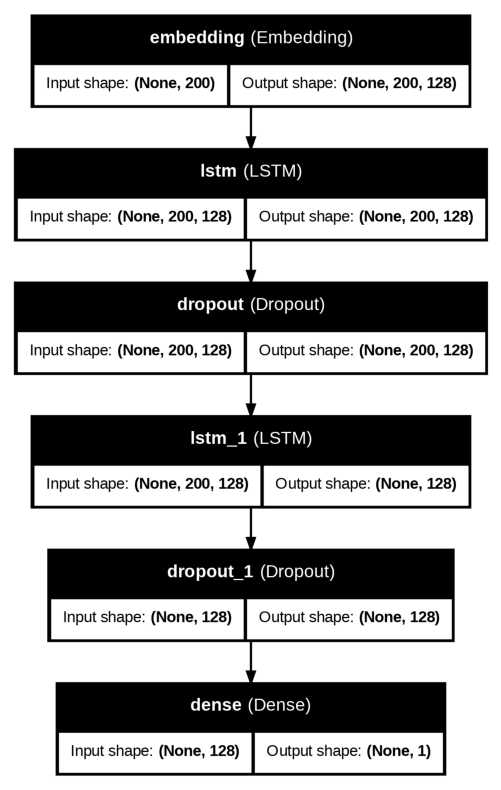

In [14]:
from tensorflow.keras.utils import plot_model

# Plot Model Architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
plt.figure(figsize=(12, 10))
img = plt.imread('model_architecture.png')
plt.imshow(img)
plt.axis('off')
plt.show()


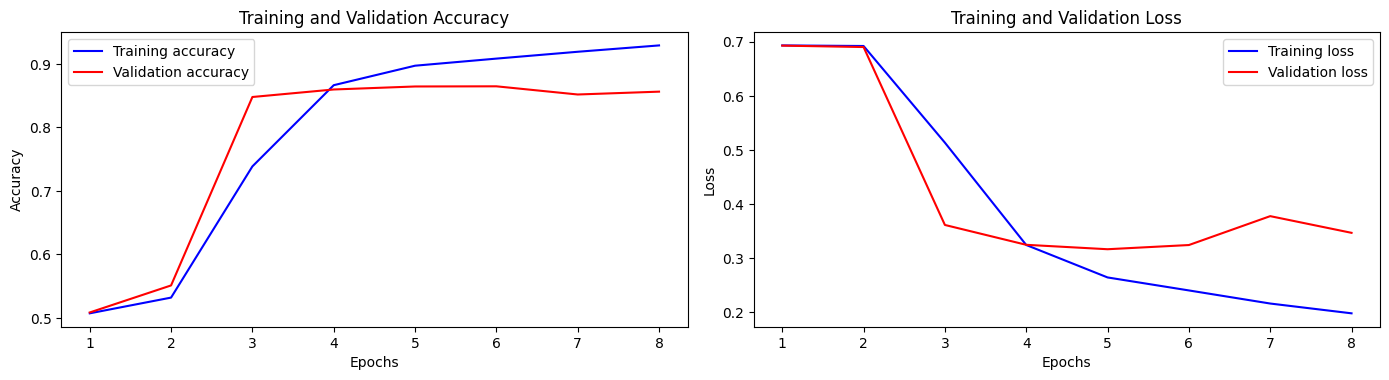

In [15]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 7))

    # Plot training and validation accuracy
    plt.subplot(2, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Check if learning rate data is available before plotting
    if 'lr' in history.history:
        # Plot the learning rate
        plt.subplot(2, 2, 3)
        learning_rate = [float(x) for x in history.history['lr']]
        plt.plot(epochs, learning_rate, 'g', label='Learning Rate')  # Use 'epochs' instead of 'epochs[1:]'
        plt.title('Learning Rate')
        plt.xlabel('Epochs')
        plt.ylabel('Learning Rate')
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)